# U-Net trained on the MoNuSeg data set

In [1]:
import random
import json
from itertools import cycle
import xml.etree.ElementTree as ET
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image
from PIL import Image, ImageDraw
from skimage.draw import polygon
from skimage.io import imread, imshow
from skimage.transform import resize
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from keras.utils import Sequence
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import pandas as pd
import tensorflow as tf

import utils
import monuseg_utils

from augmented_sequence import AugmentedSequence

In [2]:
monuseg_patinfo = pd.read_csv(Path(os.getcwd()) / 'patient_information.csv')

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 20

monuseg_train_ids = monuseg_patinfo[monuseg_patinfo['training'] == 'yes']['patient_id']
monuseg_test_ids = monuseg_patinfo[monuseg_patinfo['training'] == 'no']['patient_id']

# Perform train, validation split
monuseg_train_ids, monuseg_val_ids = utils.val_split(monuseg_train_ids)

In [4]:
seq = iaa.Sequential([
    iaa.CropToFixedSize(width=round(IMG_WIDTH*1.5), height=round(IMG_HEIGHT*1.5)),
    iaa.flip.Flipud(p=0.5),
    iaa.flip.Fliplr(p=0.5),
    iaa.Affine(rotate=(-45,45)),
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT, position="center"),
    iaa.Sometimes(0.2, iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0, 3.0)))
    #iaa.Sometimes(0.2, iaa.EdgeDetect((0,0.5)))
])

val_sequential = iaa.Sequential([
    iaa.CropToFixedSize(width=round(IMG_WIDTH*1.5), height=round(IMG_HEIGHT*1.5)),
    iaa.flip.Flipud(p=0.5),
    iaa.flip.Fliplr(p=0.5),
    iaa.Affine(rotate=(-45,45)),
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT, position="center"),
])

train_seq = AugmentedSequence(monuseg_train_ids, BATCH_SIZE, seq, IMG_WIDTH, IMG_HEIGHT)
val_seq = AugmentedSequence(monuseg_val_ids, int(BATCH_SIZE/2), val_sequential, IMG_WIDTH, IMG_HEIGHT)

(1000, 1000, 3)
(1000, 1000, 3)
(1000, 1000, 3)
(1000, 1000, 3)
(1000, 1000, 3)
(1000, 1000, 3)


(20, 256, 256, 3)
(20, 256, 256, 3)
(20, 256, 256)
(20, 256, 256, 3)
(20, 256, 256, 3)
(20, 256, 256)


<ipython-input-8-3518e4eedf02>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


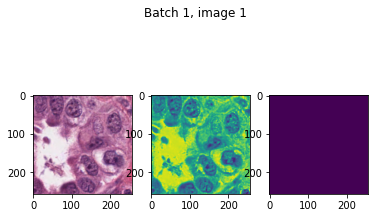

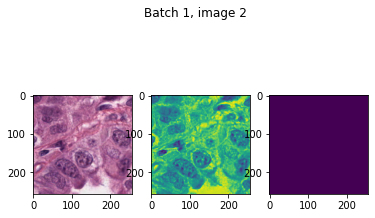

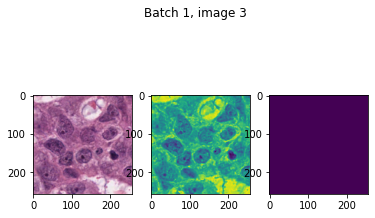

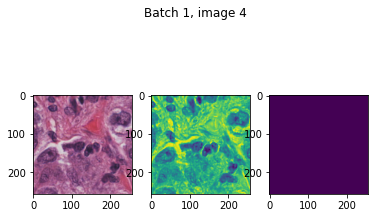

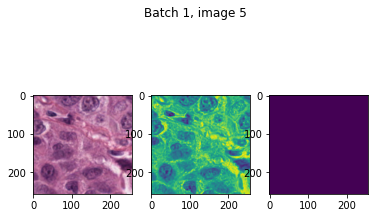

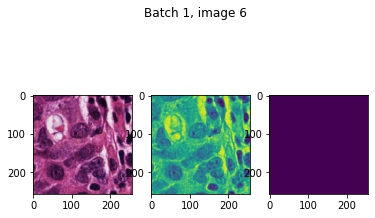

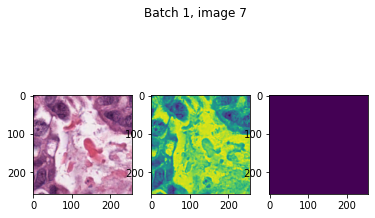

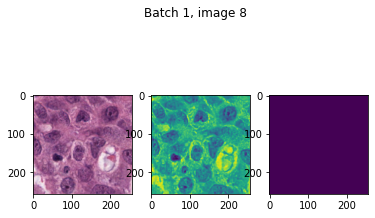

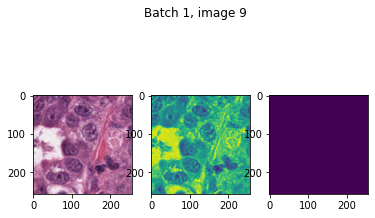

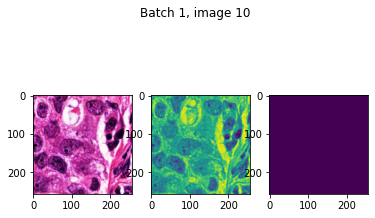

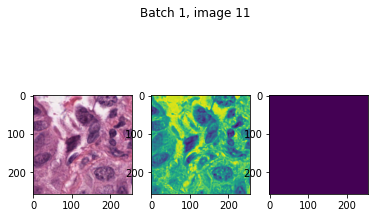

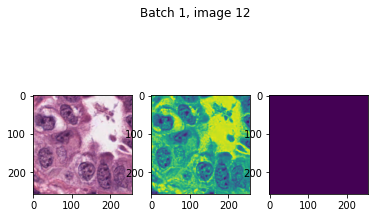

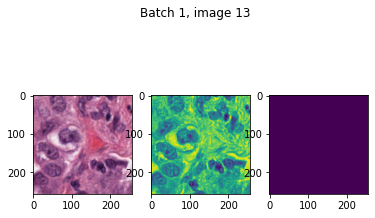

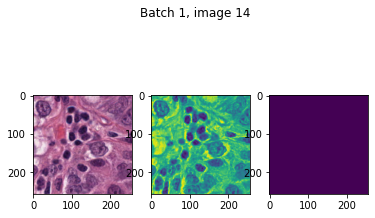

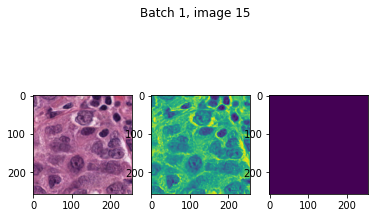

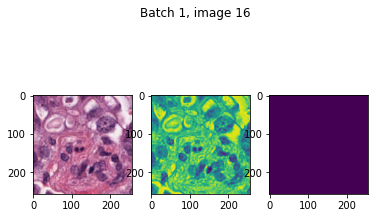

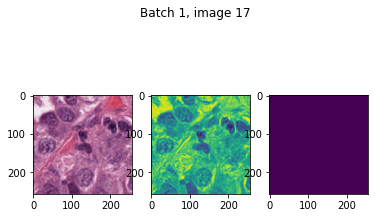

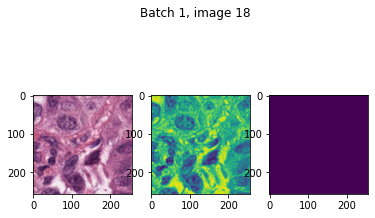

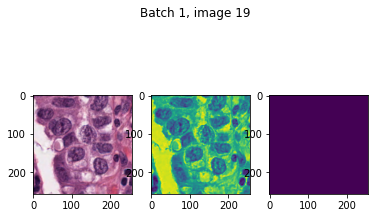

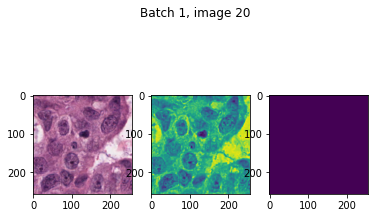

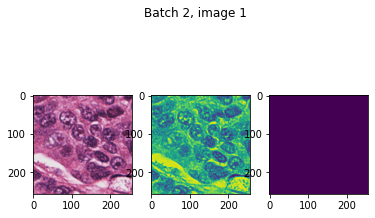

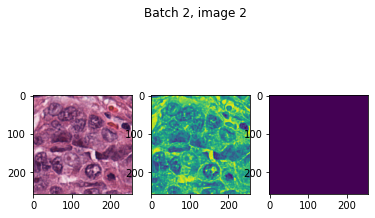

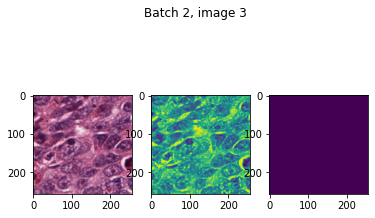

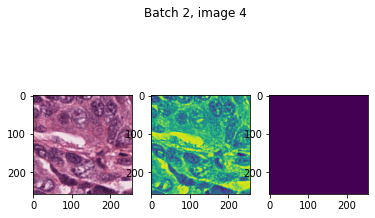

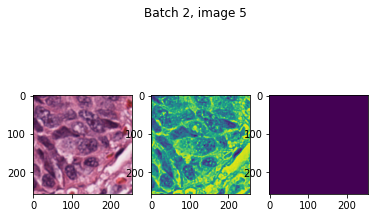

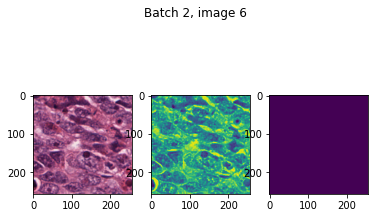

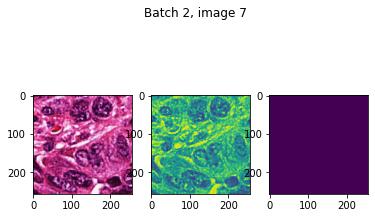

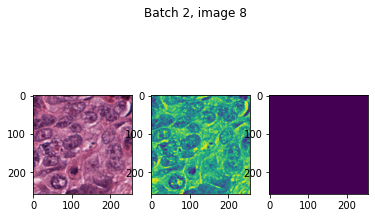

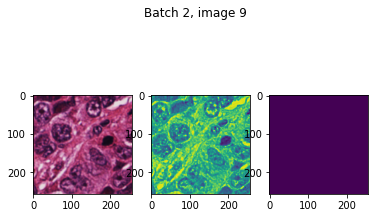

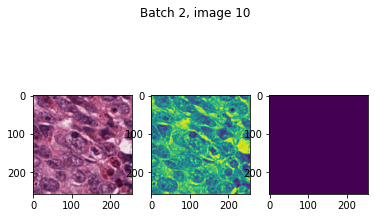

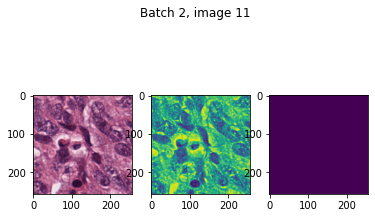

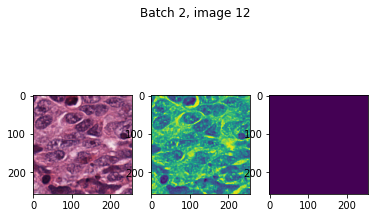

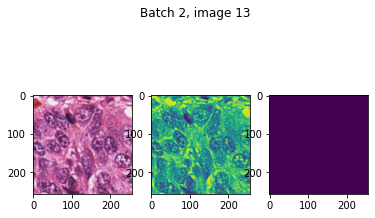

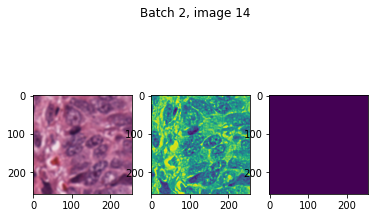

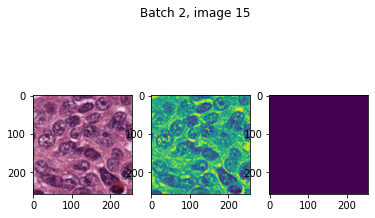

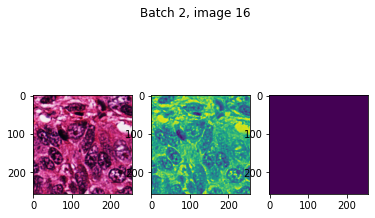

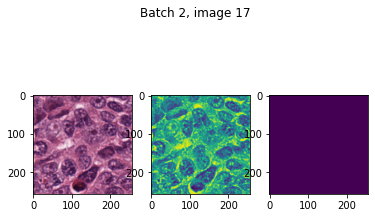

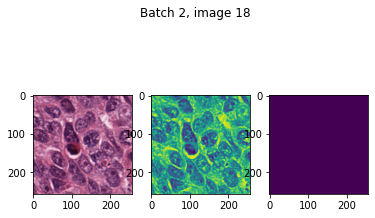

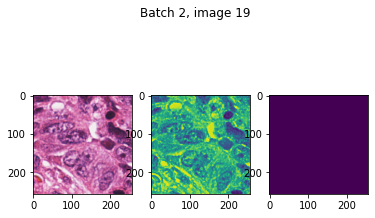

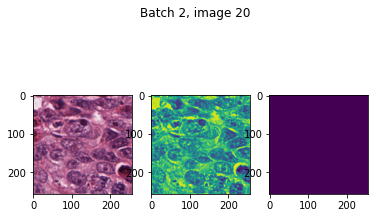

In [8]:
for i in range(2):
    bx,by,bz = train_seq[i]
    for j,(x,y,z) in enumerate(zip(bx,by,bz)):
        plt.figure()
        plt.subplot(131)
        plt.imshow(x)
        plt.subplot(132)
        plt.imshow(y[:,:,0])
        plt.subplot(133)
        plt.imshow(z[:,:])
        plt.suptitle(f"Batch {i+1}, image {j+1}")